In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<img src='images/pic1.jpg'/>

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
%autosave 180

Autosaving every 180 seconds


# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [8]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

<h3> 3.1.2 Counting the number of rows </h3>

In [9]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:01:34.650409


<h3>3.1.3 Checking for duplicates </h3>

In [10]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:16:10.687961


In [11]:
df_no_dup.head()
# we can observe that there are duplicates

Title  \
0       Implementing Boundary Value Analysis of S...   
1           Dynamic Datagrid Binding in Silverlight?   
2           Dynamic Datagrid Binding in Silverlight?   
3      java.lang.NoClassDefFoundError: javax/serv...   
4      java.sql.SQLException:[Microsoft][ODBC Dri...   

                                                Body  \
0  <pre><code>#include&lt;iostream&gt;\n#include&...   
1  <p>I should do binding for datagrid dynamicall...   
2  <p>I should do binding for datagrid dynamicall...   
3  <p>I followed the guide in <a href="http://sta...   
4  <p>I use the following code</p>\n\n<pre><code>...   

                                  Tags  cnt_dup  
0                                c++ c        1  
1          c# silverlight data-binding        1  
2  c# silverlight data-binding columns        1  
3                             jsp jstl        1  
4                            java jdbc        2

In [12]:
print("Number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

Number of duplicate questions : 1827881 ( 30.292038906260256 % )


<h3>3.1.4 Checking for the number of times each question has appeared in the database </h3>

In [0]:
#Number of times each question appeared in the database
#2656284 question occured only 1 time. 1272336 occurs 2 times. 277575 questions occurs 3 times and so on.
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [ ]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(str(text).split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

<h3>3.1.5 Checking for the distribution of number of tags per question. </h3>

In [0]:
#Distribution of number of tags per question.
#1206157 questions has 3 tags, 1111706 has 2 tags, 814996 questions has 4 tags, 568298 questions has one tag & 505158 questions has 5 tags.
df_no_dup.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

In [13]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [3]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to generate train.db file")

Time taken to run this cell : 0:00:49.192848


<h3>Observations from the above analysis.</h3>

1. There were almost 30% questions which were duplicates. So the first thing we did, is remove the duplicate questions from the actual dataset and save it in a new dataset.
2. 2656284 questions have occured only 1 time. 1272336 occurs 2 times. 277575 questions occurs 3 times and so on.
3. There are 1206157 questions which have 3 tags, 1111706 have 2 tags, 814996 questions have 4 tags, 568298 questions have one tag & 505158 questions have 5 tags. 

<h3>3.1.6 Analysis of Title texts and Body texts</h3> 

In [3]:
#Load the de-duplicated dataset
start = datetime.now()
con = sqlite3.connect('train_no_dup.db')
dataframe = pd.read_sql_query("""SELECT * FROM no_dup_train""", con)
#Always remember to close the database
con.close()

In [40]:
#Utiliy functions for feature extraction
#Counting the number of code segments present in a given body text
def count_code(string):
    if string.__contains__("<code>"):
        return string.count("<code>")
    else:
        return int(0)

#Returns the count of 'http' elements present in a string. Return 0 otherwise.
def count_http(string):
    if string.__contains__("http"):
        return string.count("http")
    else:
        return int(0)

#Returns the number of times a reference link is present in a string
def count_href(string):
    if string.__contains__("a href"):
        return string.count("a href")
    else:
        return int(0)
    
#Number of times a greater than sign appears in a string    
def count_greater(string):
    if string.__contains__(">"):
        return string.count(">")
    else:
        return int(0)

In [43]:
#Simple feature engineering
basic_feats = pd.DataFrame()
basic_feats["Length_Title"] = dataframe['Title'].apply(lambda x: len(str(x))) #Length of RAW Title text
basic_feats["Length_Body"] = dataframe['Body'].apply(lambda x: len(str(x))) #Length of RAW body text
basic_feats['count_Body_code'] = dataframe['Body'].apply(lambda x: count_code(str(x))) #Check how many code segments are present in a give body text
basic_feats['count_Body_http'] = dataframe['Body'].apply(lambda x: count_http(str(x))) #Lazy way to count the number of URLs present in a body text. Not 100% accurate, but close enough
basic_feats['count_Body_href'] = dataframe['Body'].apply(lambda x: count_href(str(x))) #Lazy way to count the reference to an externel site. Not 100% accurate, but close enough
basic_feats['count_Body_grtsign'] = dataframe['Body'].apply(lambda x: count_greater(str(x))) #Very lazy way to count html tags present in a string. Not 100% accurate, but close enough

#Save the dataset containing basic features
basic_feats.to_csv('basic_feats.csv', columns=basic_feats.columns)
basic_feats.head()

Length_Title  Length_Body  count_Body_code  count_Body_http  \
0            79         2037                2                0   
1            44          860                1                0   
2            44          860                1                0   
3            80          665                2                2   
4            83          973                2                0   

   count_Body_href  count_Body_grtsign  
0                0                  14  
1                0                   8  
2                0                   8  
3                1                  18  
4                0                  14

<h3>3.1.7 High level statistics of the dataset containing simple features </h3> 

In [48]:
#Get a high level stats of the given dataset
basic_feats.describe()

Length_Title   Length_Body  count_Body_code  count_Body_http  \
count  4.206315e+06  4.206315e+06     4.206315e+06     4.206315e+06   
mean   5.079118e+01  1.120116e+03     1.574385e+00     5.555927e-01   
std    2.006422e+01  1.487497e+03     2.478619e+00     1.792181e+00   
min    5.000000e+00  4.000000e+00     0.000000e+00     0.000000e+00   
25%    3.600000e+01  4.160000e+02     0.000000e+00     0.000000e+00   
50%    4.800000e+01  7.250000e+02     1.000000e+00     0.000000e+00   
75%    6.200000e+01  1.285000e+03     2.000000e+00     0.000000e+00   
max    2.190000e+02  4.825800e+04     5.000000e+02     5.000000e+02   

       count_Body_href  count_Body_grtsign  
count     4.206315e+06        4.206315e+06  
mean      2.690229e-01        1.538712e+01  
std       9.447945e-01        1.337127e+01  
min       0.000000e+00        0.000000e+00  
25%       0.000000e+00        6.000000e+00  
50%       0.000000e+00        1.200000e+01  
75%       0.000000e+00        2.000000e+01  
max       3.420000e+02        1.886000e+03

In [80]:
#Get the percentage of questions which does not have a code snippet included in their body
zero = basic_feats[basic_feats['count_Body_code'] == 0].shape[0]
per = (zero/basic_feats.shape[0]) * 100
print("Percentage of users who have not included any code snippet in the body text: {:.2f}%".format(per))

#Get the percentage of questions which does not have a http referrence included in their body
zero = basic_feats[basic_feats['count_Body_http'] == 0].shape[0]
per = (zero/basic_feats.shape[0]) * 100
print("Percentage of users who have not included any http referrence URL in the body text: {:.2f}%".format(per))

#Get the percentage of questions which are provided with external reference links in their body text
zero = basic_feats[basic_feats['count_Body_href'] == 0].shape[0]
per = (1-zero/basic_feats.shape[0]) * 100
print("Percentage of users who have used an external referrence in their body text: {:.2f}%".format(per))

Percentage of users who have not included any code snippet in the body text: 42.30%
Percentage of users who have not included any http referrence URL in the body text: 76.14%
Percentage of users who have used an external referrence in their body text: 17.39%


### Observations from the above analysis:

1. A quick high level statistic revealed that the average length of reviews are somewhere around 50. 
2. Most users (50%) writes title text between 36 and 62 characters. 
3. The average length of the body text given by all the users is somewhere around 1120 characters. 
4. Almost 25% users has used an external reference in their question ('href' tag). 
5. More than 50% users writes 725 words on an average to describe the problem. 
6. On an average, each user has included less than 1 URLs in their body text.
7. There are almost 42% questions which does not have any code snippet included in the body text.
8. More than 75% questions have 2 or more code snippets included.
9. The maximum length of body text seen for any user is as long as 48K characters!
10. As many as 76% users did not include any http URL in their body text.
11. As many as 17% users used an external link in their body text

<h3>3.1.8 Histograms of some of the extracted features</h3> 

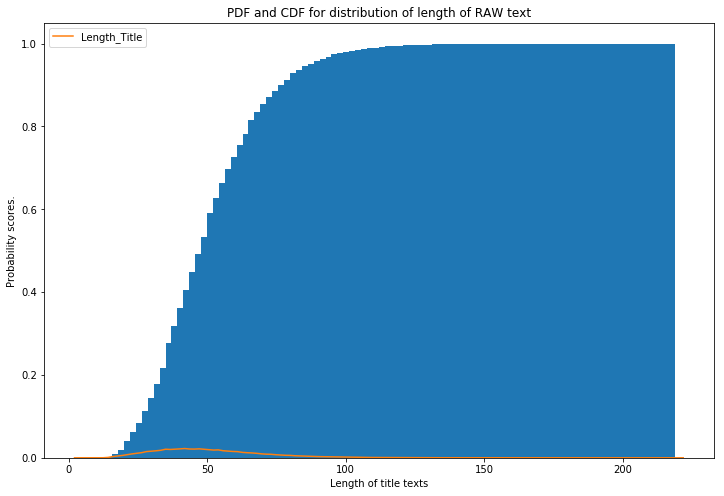

In [104]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics

plt.figure(figsize=(12, 8))
myHist = plt.hist(basic_feats['Length_Title'].values, 100, density=True, cumulative=True)
plt.title('PDF and CDF for distribution of length of RAW text')
plt.xlabel('Length of title texts')
plt.ylabel('Probability scores.')
sns.kdeplot(basic_feats['Length_Title']);
plt.show()

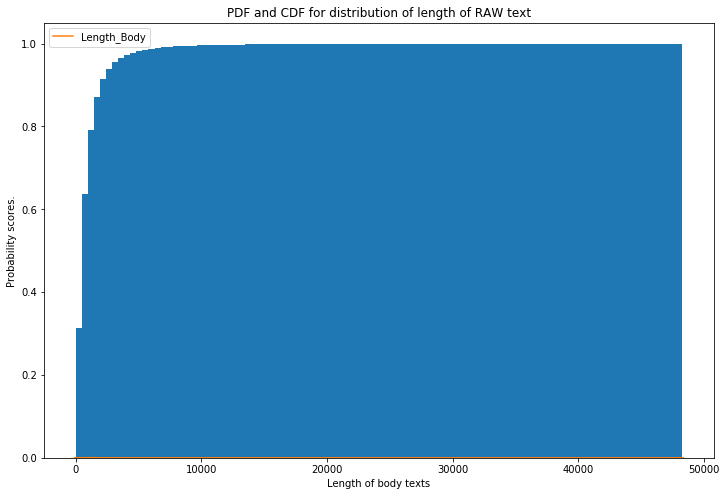

In [120]:
plt.figure(figsize=(12, 8))
myHist = plt.hist(basic_feats['Length_Body'].values, 100, density=True, cumulative=True)
plt.title('PDF and CDF for distribution of length of RAW text')
plt.xlabel('Length of body texts')
plt.ylabel('Probability scores.')
sns.kdeplot(basic_feats['Length_Body']);
plt.show()

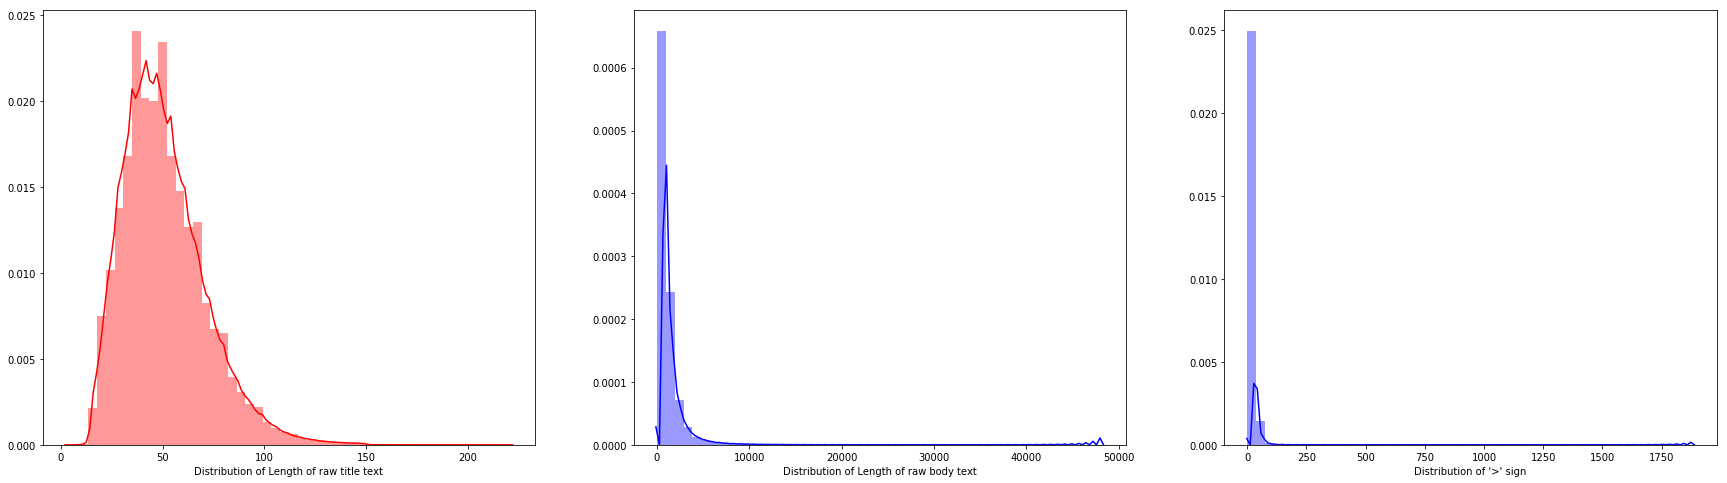

In [119]:
#Draw only PDF 
plt.figure(figsize=(30, 8))
plt.subplot(1,3,1)
sns.distplot([basic_feats['Length_Title']], color = 'red', axlabel="Distribution of Length of raw title text")
plt.subplot(1,3,2)
sns.distplot([basic_feats['Length_Body']], color = 'blue', axlabel="Distribution of Length of raw body text")
plt.subplot(1,3,3)
sns.distplot([basic_feats['count_Body_grtsign']], color = 'blue', axlabel="Distribution of '>' sign")
plt.show()

### Observations:

1. We can see most of the title texts has median length around 50.
2. The median length of the body texts are around 750. 
3. Each user, on an average gives 12 HTML tags.
4. All the distributions are mostly left skewed. 
5. From the CDF, we can tell that almost 99% of the questions have title length less than 100, and almost 99% of the questions has body length less than 2000 words.

<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [15]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool.
#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model and learns the vocabulary; second, it transforms our training data into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [16]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [17]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [18]:
#https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1 #axis=0 for columns. Column contain the number of times the tags have occured
result = dict(zip(tags, freqs))

In [3]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

Tags  Counts
0             .a      18
1           .app      37
2   .asp.net-mvc       1
3      .aspxauth      21
4  .bash-profile     138

In [7]:
#Sort the tags according to their number of occurences.
#We see that c#, java, php, javascript and android are the 5 most frequently occuring tags.
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_df_sorted.head()

Tags  Counts
4337           c#  331505
18069        java  299414
27249         php  284103
18157  javascript  265423
1234      android  235436

In [21]:
#tag_counts contains how many times each tags appeared.
tag_counts

array([331505, 299414, 284103, ...,      1,      1,      1])

<h3>Analysis of Tags : Distribution of all 42K tags, i.e the number of times each tag appeared in questions.</h3>

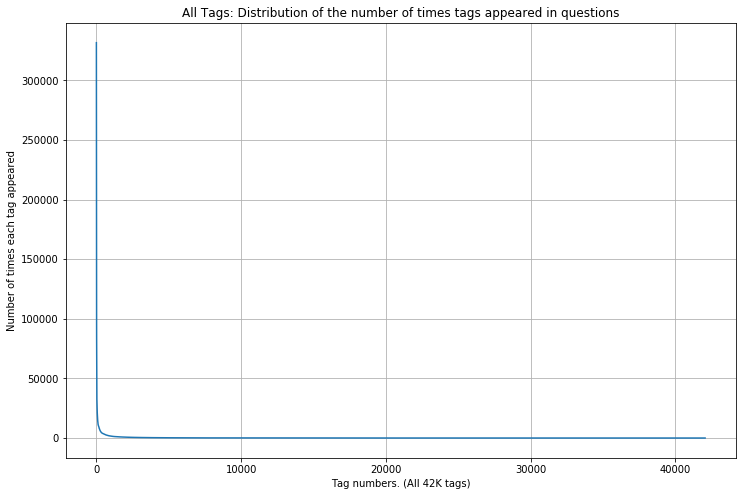

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(tag_counts)
plt.title("All Tags: Distribution of the number of times tags appeared in questions")
plt.grid()
plt.xlabel("Tag numbers. (All 42K tags)")
plt.ylabel("Number of times each tag appeared")
plt.show()

<h3>Analysis of Tags : Zooming in. Distribution of all first 10K tags, i.e the number of times each tag appeared in questions.</h3>

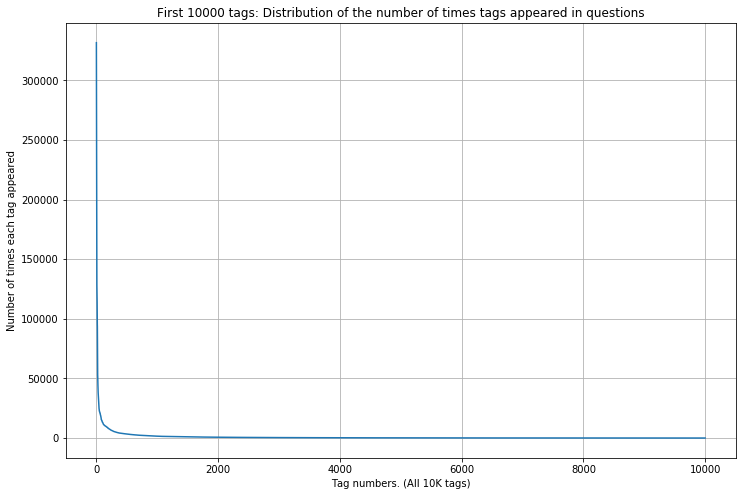

Frequency of occurence of top 400 tags

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2989   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    3

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(tag_counts[0:10000])
plt.title('First 10000 tags: Distribution of the number of times tags appeared in questions')
plt.grid()
plt.xlabel("Tag numbers. (All 10K tags)")
plt.ylabel("Number of times each tag appeared")
plt.show()
print("Frequency of occurence of top 400 tags\n")
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

<h3>Analysis of Tags : Zooming in. Distribution of all first 1000 tags, i.e the number of times each tag appeared in questions.</h3>

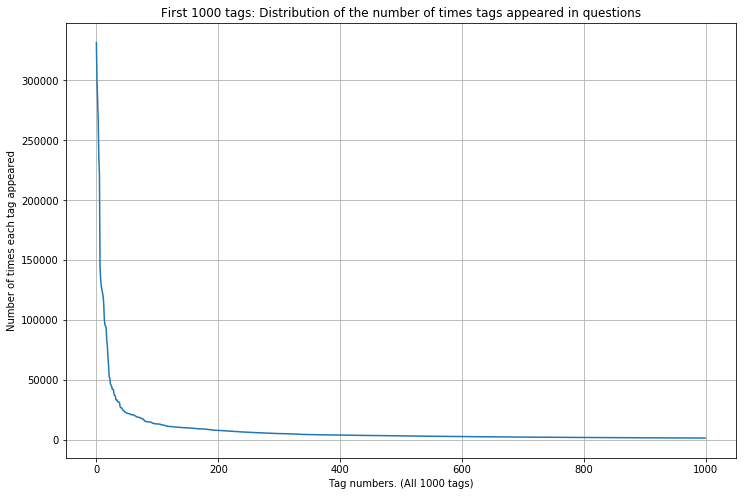

Frequency of occurence of top 200 tags

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2989   2984   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   25

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(tag_counts[0:1000])
plt.title('First 1000 tags: Distribution of the number of times tags appeared in questions')
plt.grid()
plt.xlabel("Tag numbers. (All 1000 tags)")
plt.ylabel("Number of times each tag appeared")
plt.show()
print("Frequency of occurence of top 200 tags\n")
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

<h3>Analysis of Tags : Zooming in. Distribution of all first 500 tags, i.e the number of times each tag appeared in questions.</h3>

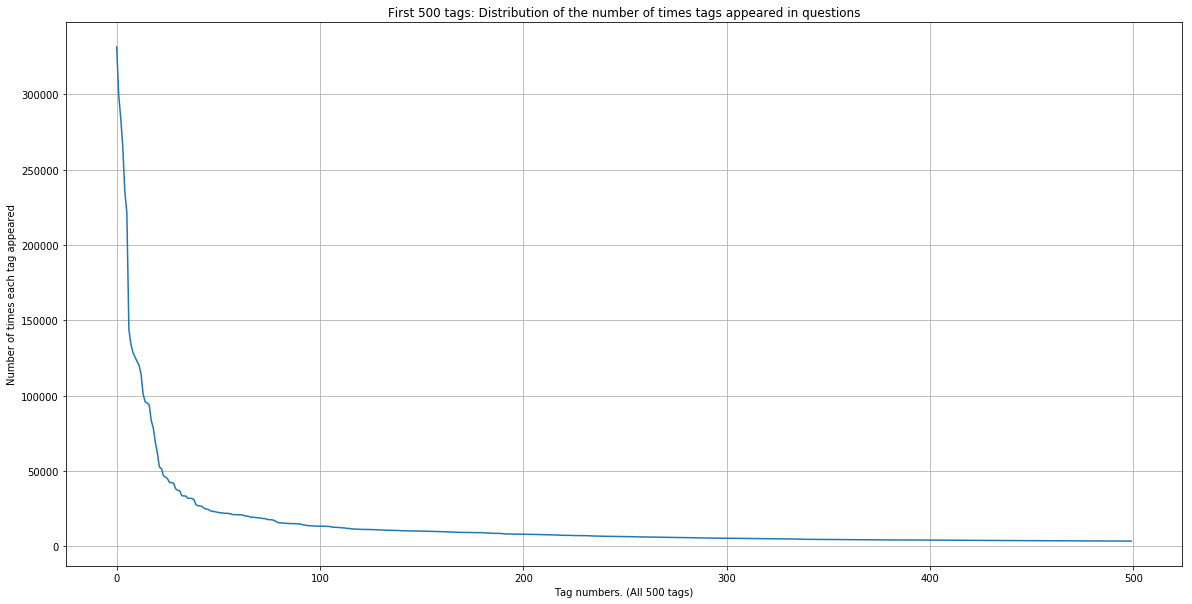

Frequency of occurence of 100 tags

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [31]:
plt.figure(figsize=(12, 8))
plt.plot(tag_counts[0:500])
plt.title('First 500 tags: Distribution of the number of times tags appeared in questions')
plt.grid()
plt.xlabel("Tag numbers. (All 500 tags)")
plt.ylabel("Number of times each tag appeared")
plt.show()
print("Frequency of occurence of 100 tags\n")
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

<h3>Analysis of Tags : Distribution of all first 100 tags, i.e the number of times each tag appeared in questions.</h3>

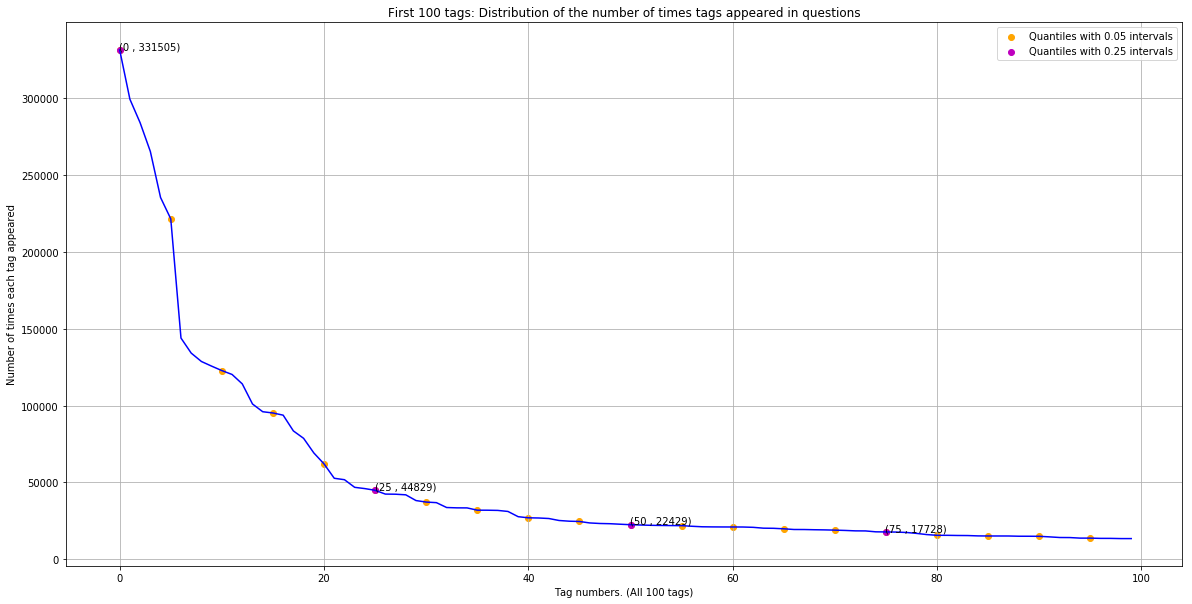

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [32]:
plt.figure(figsize=(12, 8))
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="Quantiles with 0.05 intervals") #quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "Quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('First 100 tags: Distribution of the number of times tags appeared in questions')
plt.grid()
plt.xlabel("Tag numbers. (All 100 tags)")
plt.ylabel("Number of times each tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [36]:
#Store tags greater than 10K in one list
list_tags_grt_thn_10k = tag_df_sorted[tag_df_sorted.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(list_tags_grt_thn_10k)))

# Store tags greater than 100K in one list
list_tags_grt_thn_100k = tag_df_sorted[tag_df_sorted.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(list_tags_grt_thn_100k)))

#Tags with the most frequency
print("Most frequently occuring tag: {}".format(tag_df_sorted.iloc[0][0]))
print("Number of times {} occurs: {}".format(tag_df_sorted.iloc[0][0],tag_counts[0]))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times
Most frequently occuring tag: c#
Number of times c# occurs: 331505


In [37]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags that are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags that are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags that are used more than 10000 times
14 Tags that are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [38]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [39]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


<h3>Histogram for distribution of tags.</h3>

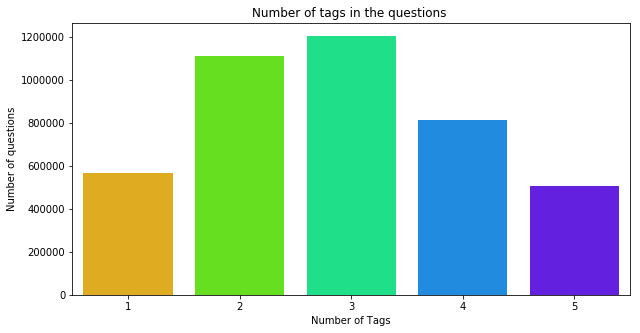

In [40]:
plt.figure(figsize=(10,5))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<h3>Observations from the above analysis.</h3>

1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags, and a vast majority of questions also has 4 tags. 5 and 1 tags are there in comparitively lower number of questions.

<h3>3.2.5 Most Frequent Tags </h3>

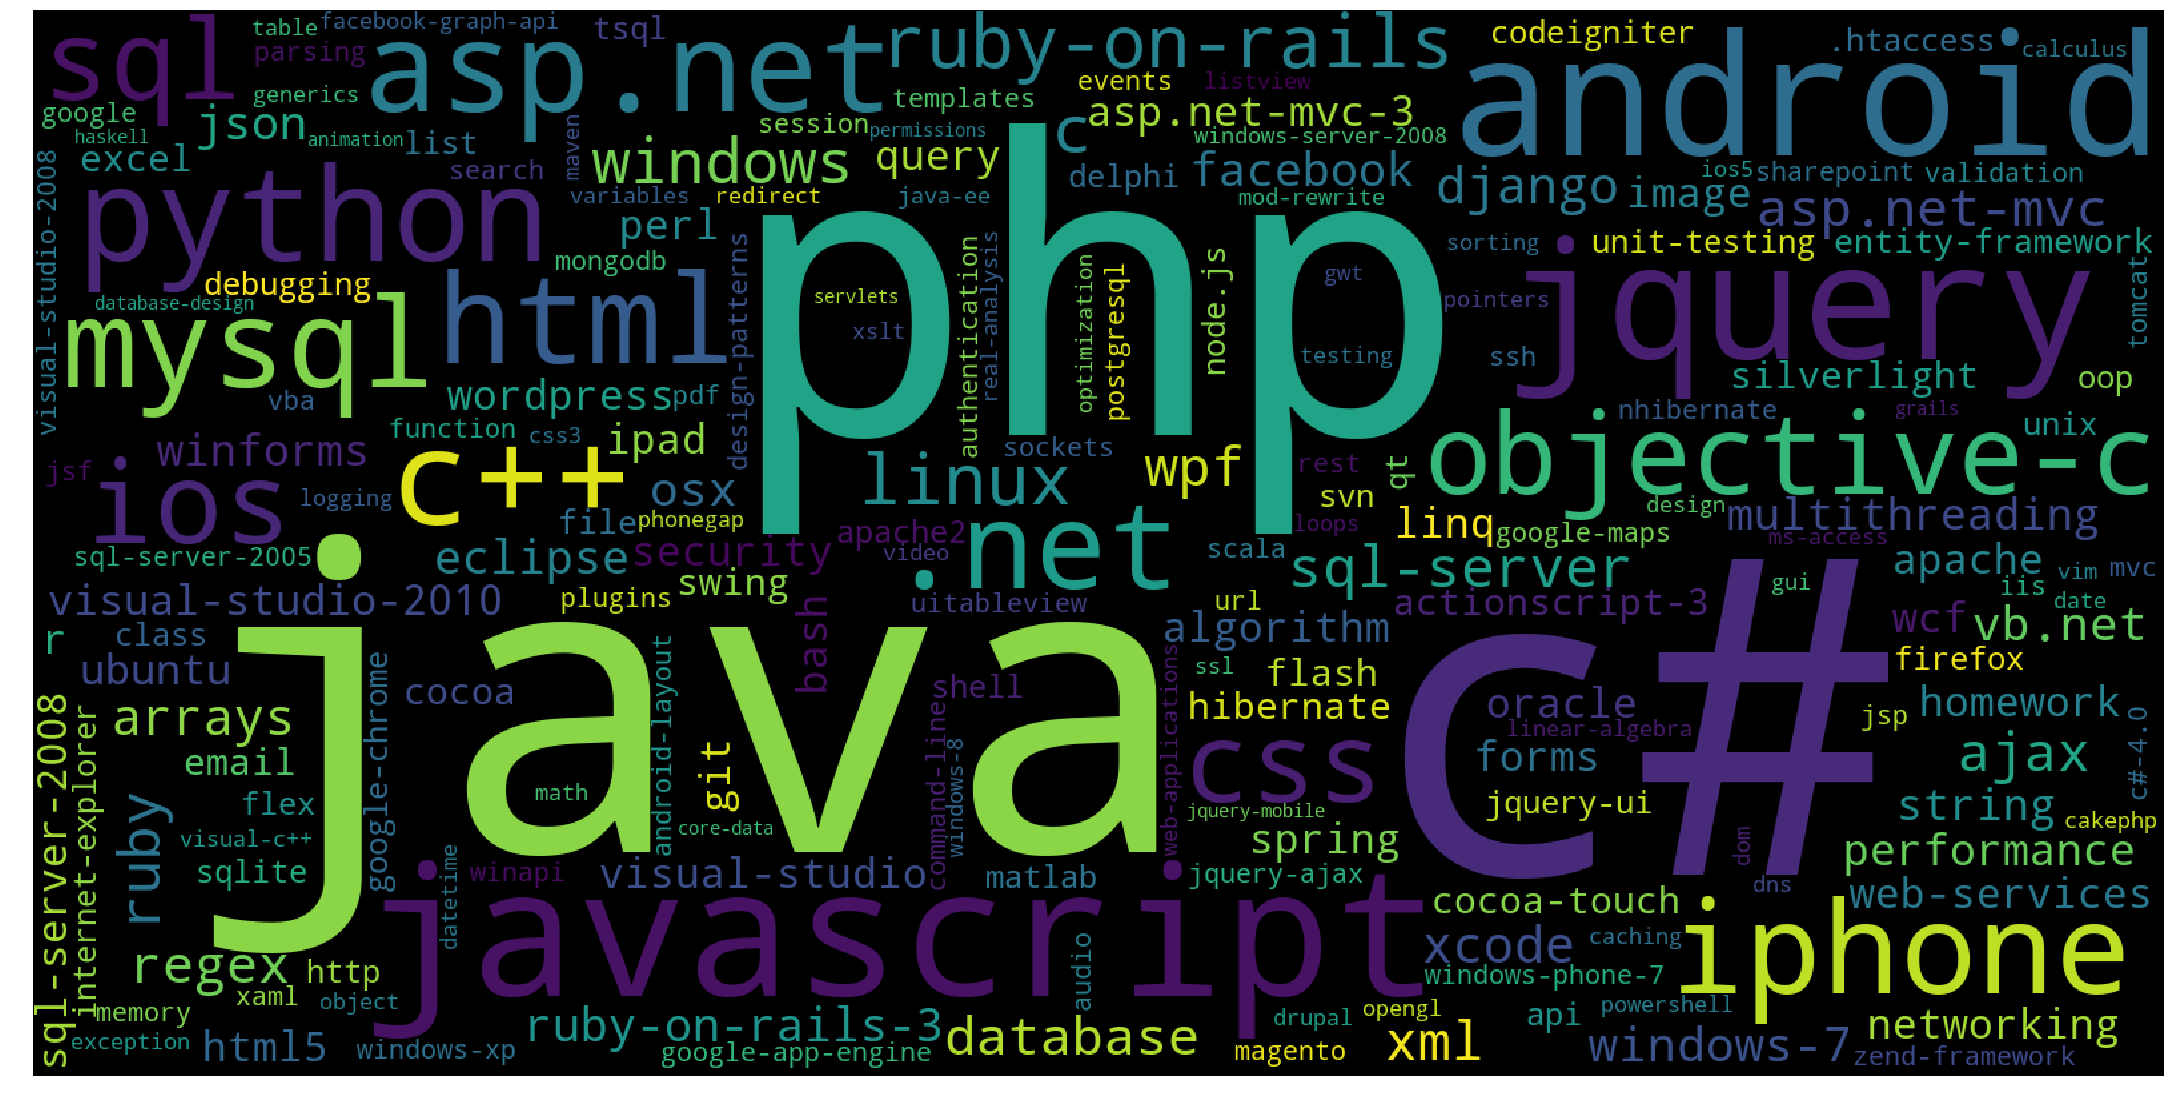

Time taken to run this cell : 0:00:05.515045


In [41]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<h3>Observations from the above word cloud.</h3>

A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags, closely followed by "python", "jquery", "html". This suggests c# is the most talked about programming language in StackOverflow. In terms of mobile operating systems, we see that "android" is the most popular platform closely followed by "iphone" and "ios". People have asked more questions about "linux" than about "windows".

<h3> 3.2.6 The top 50 tags </h3>

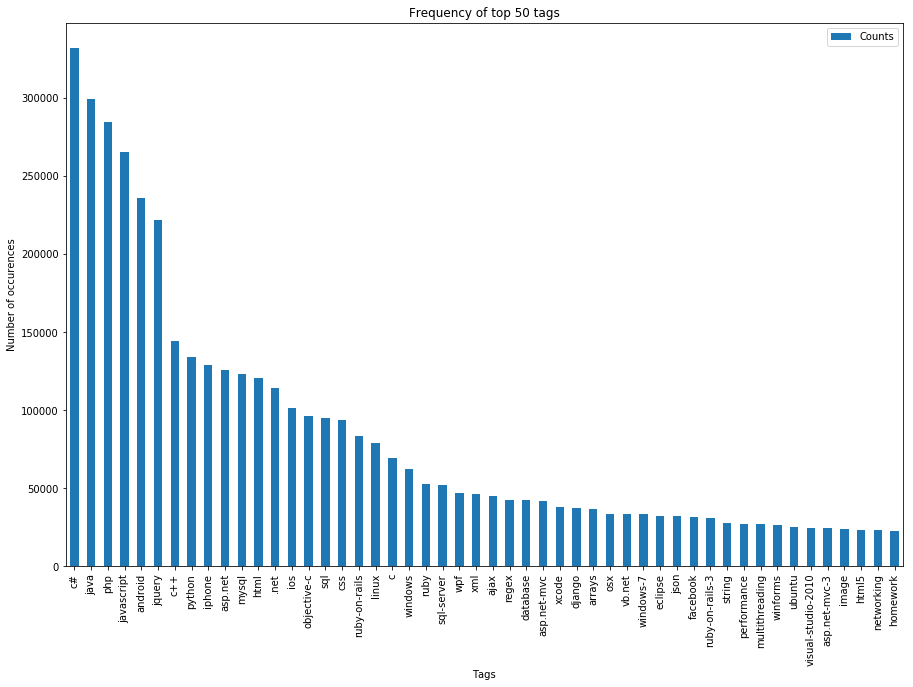

In [8]:
i=np.arange(50)
tag_df_sorted.head(50).plot(kind='bar', figsize=(15,10), rot=90)
plt.title('Frequency of top 50 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Number of occurences')
plt.show()

<h3>Observations from the above plot.</h3>

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language, followed by java, php, javascript.
3. Android, IOS, Linux and Windows are among the top most frequent operating systems.
4. MySQL and SQL-Server are the most popular databases.

<h3> 3.2.7 The least fruquent 50 tags </h3>

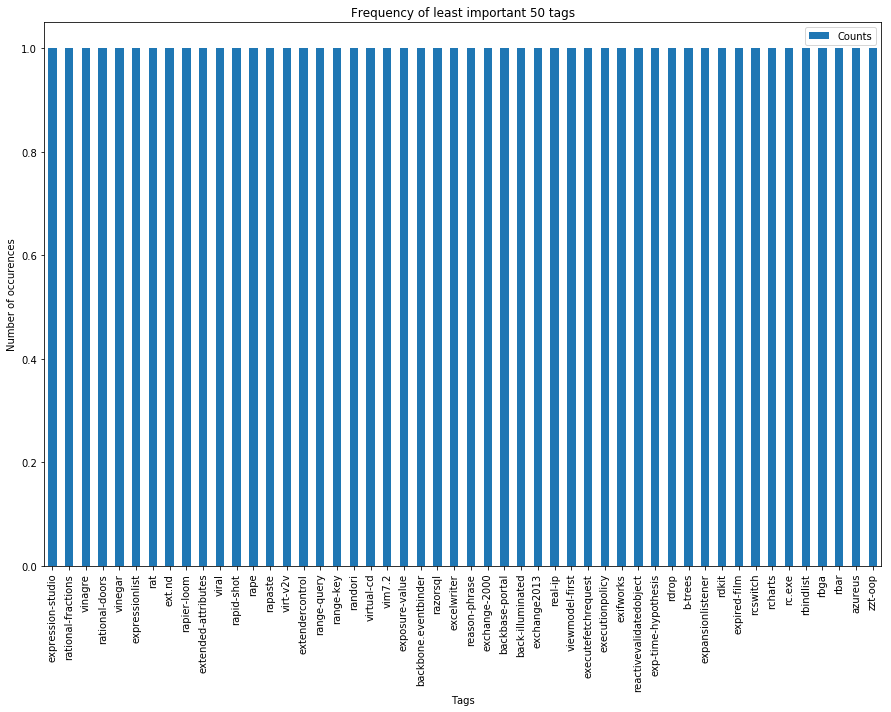

In [8]:
i=np.arange(50)
tag_df_sorted.tail(50).plot(kind='bar', figsize=(15,10), rot=90)
plt.title('Frequency of least important 50 tags')
plt.xticks(i, tag_df_sorted['Tags'][-50:])
plt.xlabel('Tags')
plt.ylabel('Number of occurences')
plt.show()

In [18]:
#These are the least 50 important tags
print(list(tag_df_sorted['Tags'][-50:]))

['expression-studio', 'rational-fractions', 'vinagre', 'rational-doors', 'vinegar', 'expressionlist', 'rat', 'ext.nd', 'rapier-loom', 'extended-attributes', 'viral', 'rapid-shot', 'rape', 'rapaste', 'virt-v2v', 'extendercontrol', 'range-query', 'range-key', 'randori', 'virtual-cd', 'vim7.2', 'exposure-value', 'backbone.eventbinder', 'razorsql', 'excelwriter', 'reason-phrase', 'exchange-2000', 'backbase-portal', 'back-illuminated', 'exchange2013', 'real-ip', 'viewmodel-first', 'executefetchrequest', 'executionpolicy', 'exifworks', 'reactivevalidatedobject', 'exp-time-hypothesis', 'rdrop', 'b-trees', 'expansionlistener', 'rdkit', 'expired-film', 'rcswitch', 'rcharts', 'rc.exe', 'rbindlist', 'rbga', 'rbar', 'azureus', 'zzt-oop']


<h3> 3.2.8 EDA using K-Means Clustering on BOW representations of tags</h3> 

In [38]:
from sklearn.cluster import KMeans

#Elbow method to determine the best value of K in K-Means clustering.
def plot_elbow(sumOfSquaredErrors, n_clusters, vectorizationType):
    '''This function is used to plot the elbow curve for sum of squared errors vs cluster values and obtain the optimal 
    value of the hyperparameter K.'''
        
    k_values = n_clusters
    loss = sumOfSquaredErrors
    
    #Plot K_Values vs Loss Values
    plt.figure(figsize=(35,8))
    plt.plot(k_values,loss,color='red',linestyle='dashed',linewidth=5,marker='o',markerfacecolor='blue',markersize=10)
    for xy in zip(k_values, np.round(loss,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('K vs Loss for {} model'.format(vectorizationType))
    plt.xlabel('Number of clusters')
    plt.ylabel('Loss (Sum of Squared Errors)')
    plt.show()
    
    optimal_k = input("Please select the optimal numberof clusters from the above elbow plot and press enter : ")
    print("The optimal number of clusters selected from the elbow method is {}".format(optimal_k))
    
    return optimal_k

#Function to perform KMeans Clustering.
def KMeansPlusPlus(tags_vectors):
    '''This function is used for multiple method calls which would determine the optimal value of k. The loss is calculated for each clusters and the value of the optimal 
    number of clusters is obtained by visualy examining the elbow plot. At the end the k-means algorithm will be run with the best value of K selected from the elbow plot'''
    t_start = datetime.now()
    sumOfSquaredErrors = []
    n_clusters = range(1,25)
    k_means = [KMeans(n_clusters=i, n_init=5, init='k-means++', n_jobs=8, random_state=0) for i in n_clusters] # algorithm = elkan for dense data data, default: algorithm = auto
    k_means_centroids = [k_mean.fit(tags_vectors) for k_mean in k_means]
    sumOfSquaredErrors = [k_mean.inertia_ for k_mean in k_means_centroids] # Inertia: Sum of distances of samples to their closest cluster center   
    optimal_k = int(plot_elbow(sumOfSquaredErrors, n_clusters, "BOW"))
    
    #Run k-medoids with the optimal number of clusters obtained from the elbow method
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', algorithm='auto', n_jobs=8, random_state=0).fit(tags_vectors)
    print("Time taken to perform K-Means clustering on Tags data: ",datetime.now() - t_start)
    
    return kmeans, optimal_k

#Function to draw word clouds for each clusters.
from wordcloud import WordCloud 
def word_clouds(kmeans_object, tags_corpus):
    #Labels of each data point
    labels=kmeans_object.labels_
    clusters_dict = {i: np.where(labels == i)[0] for i in range(optimal_k)}
    # Transform this dictionary into list (if you need a list as result)
    clusters_list = []
    print("The number of datapoints in each cluster are as follows : ")
    for key, value in clusters_dict.items():
        temp = [key,value]
        clusters_list.append(temp)
        print("Cluster = {}, Number of data points = {}".format(key+1,len(value)))

    from wordcloud import WordCloud    
    for cluster_number in range(optimal_k):
        cluster = [clusters_dict[cluster_number][i] for i in range(clusters_dict[cluster_number].size)]

        reviews_cluster = []
        for i in cluster: 
            reviews_cluster.append(tags_corpus[i])

        review_corpus = ""   
        for review in reviews_cluster:
            review_corpus = review_corpus + " " + review

        # lower max_font_size
        wordcloud = WordCloud(width=800, height=450, margin=2, prefer_horizontal=0.9, scale=1, max_words=75, 
                              min_font_size=4, random_state=42, background_color='black', 
                              contour_color='black', repeat=False).generate(str(review_corpus))
        plt.figure(figsize=(16,9))
        plt.title("Word Cloud for Cluster {}".format(cluster_number+1))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

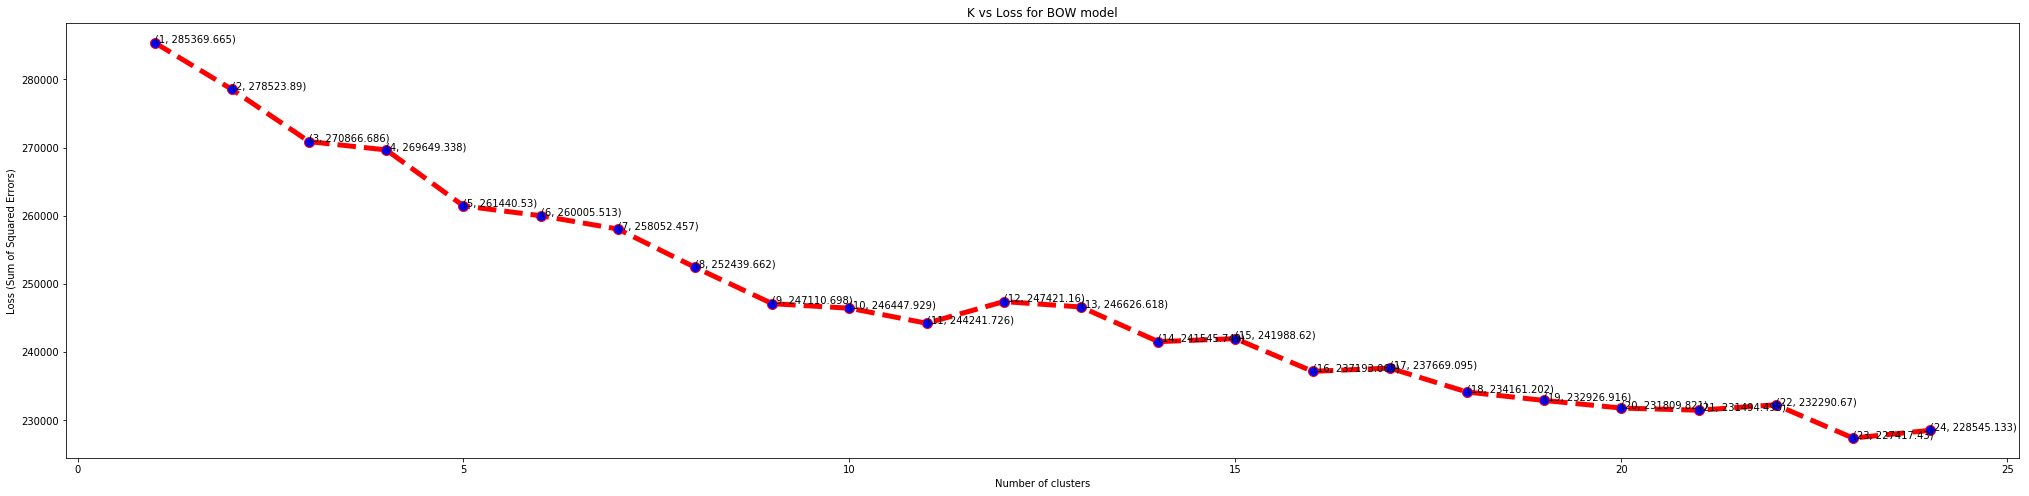

Please select the optimal numberof clusters from the above elbow plot and press enter : 10
The optimal number of clusters selected from the elbow method is 10
Time taken to perform K-Means clustering on Tags data:  0:33:44.131575


In [39]:
#Taking 100000K data points sampled randomly from tags_data. Not taking all the datapoints
data = tag_data.sample(n=100000, random_state=0).reset_index().drop(columns='index')
tags_corpus=data['Tags'].apply(lambda x: str(x)) #Avoid encoding problems
cv_object = CountVectorizer(dtype='float',tokenizer = lambda x: x.split()).fit(tags_corpus) #Initializing the BOW constructor
tags_vectors = cv_object.transform(tags_corpus) #Creating BOW vectors of all the tags
#tags_vectors = standardize(tags_bow, False) #Column Standardization of the Bag of Words vector 
kmeans_object, optimal_k = KMeansPlusPlus(tags_vectors) #KMeans++ Algorithm function call to get the best kmeans object and optimal number of clusters

The number of datapoints in each cluster are as follows : 
Cluster = 1, Number of data points = 5470
Cluster = 2, Number of data points = 7699
Cluster = 3, Number of data points = 6130
Cluster = 4, Number of data points = 56729
Cluster = 5, Number of data points = 4620
Cluster = 6, Number of data points = 5563
Cluster = 7, Number of data points = 2794
Cluster = 8, Number of data points = 458
Cluster = 9, Number of data points = 8502
Cluster = 10, Number of data points = 2035


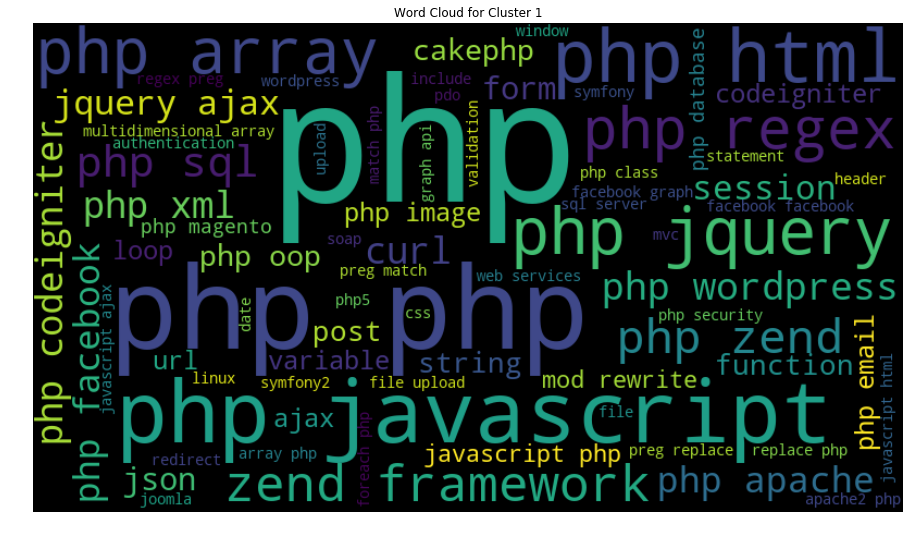

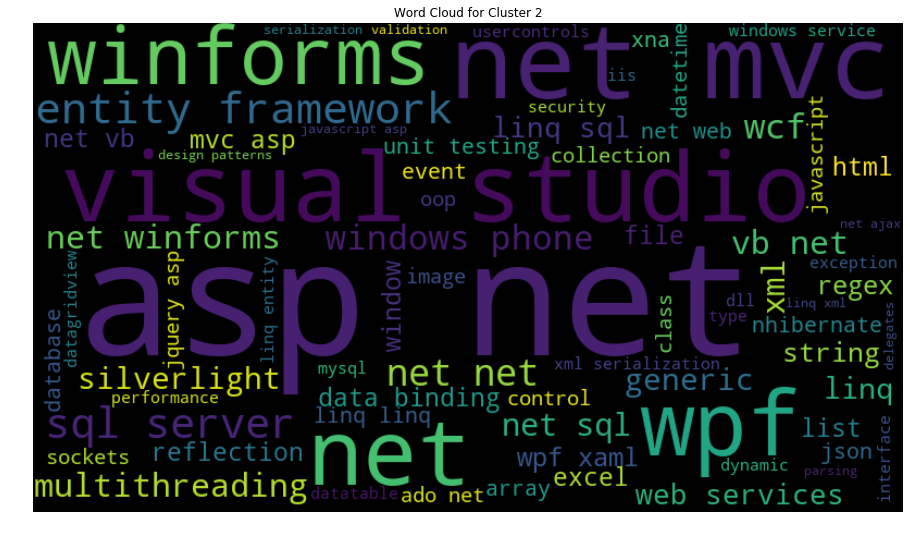

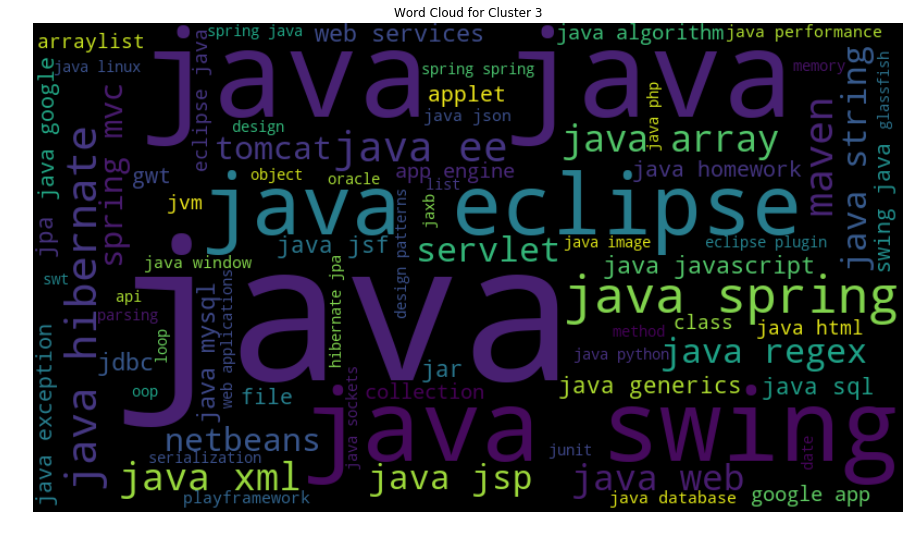

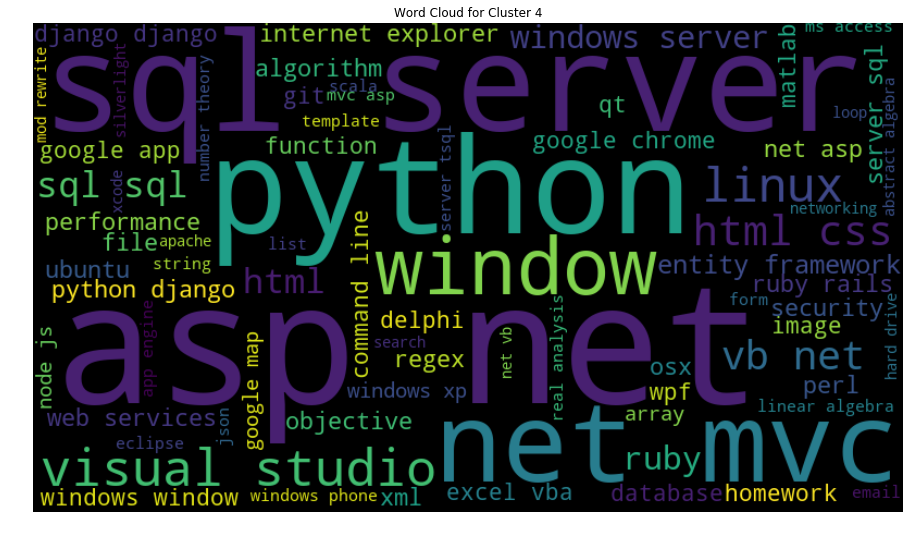

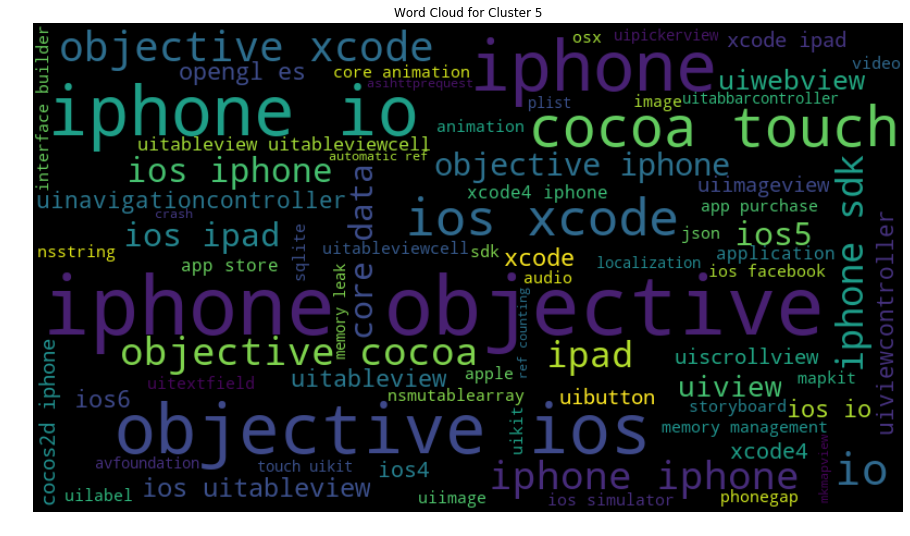

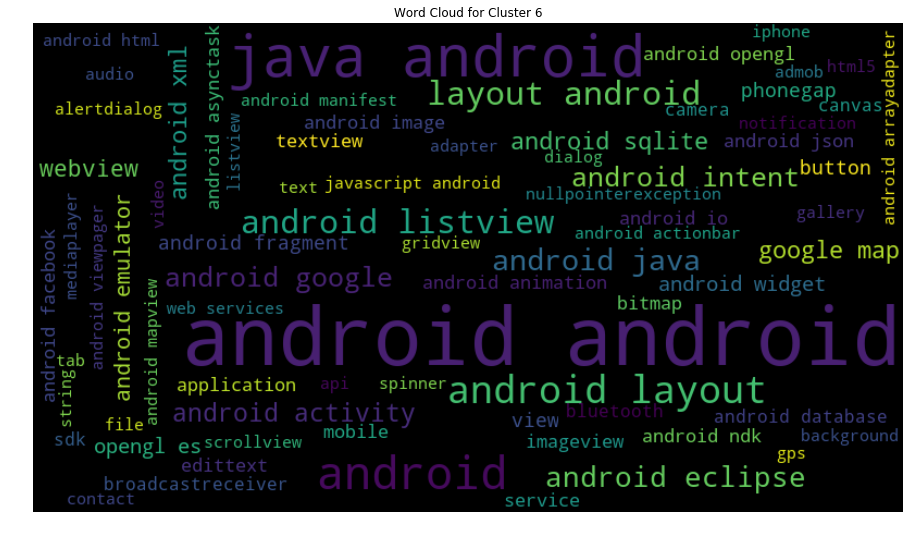

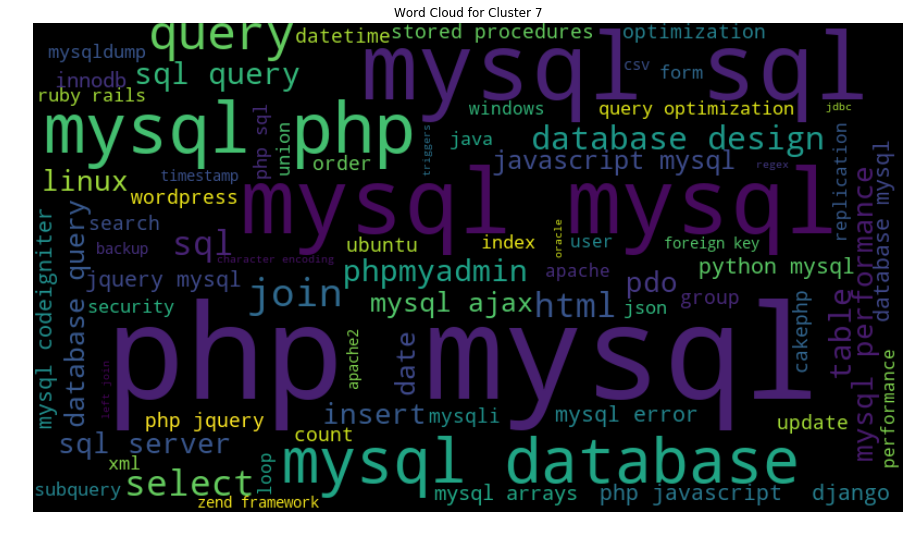

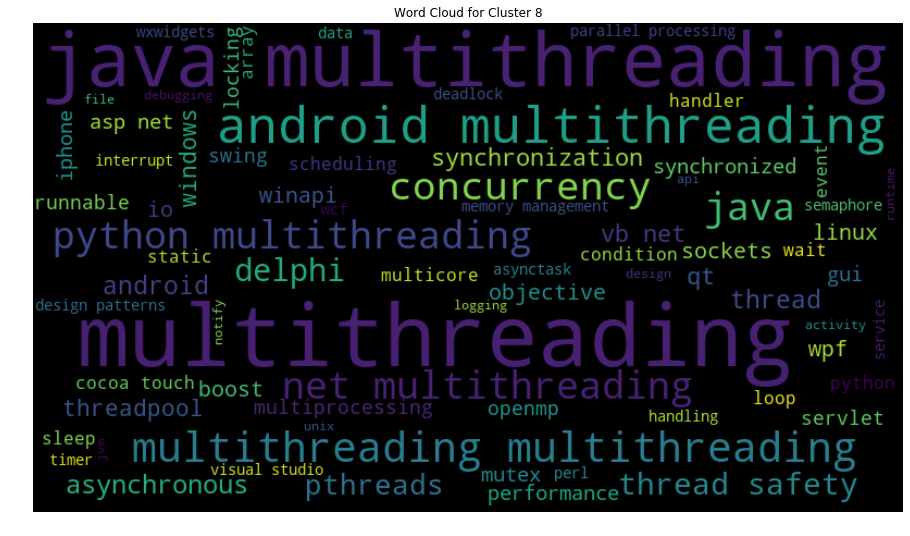

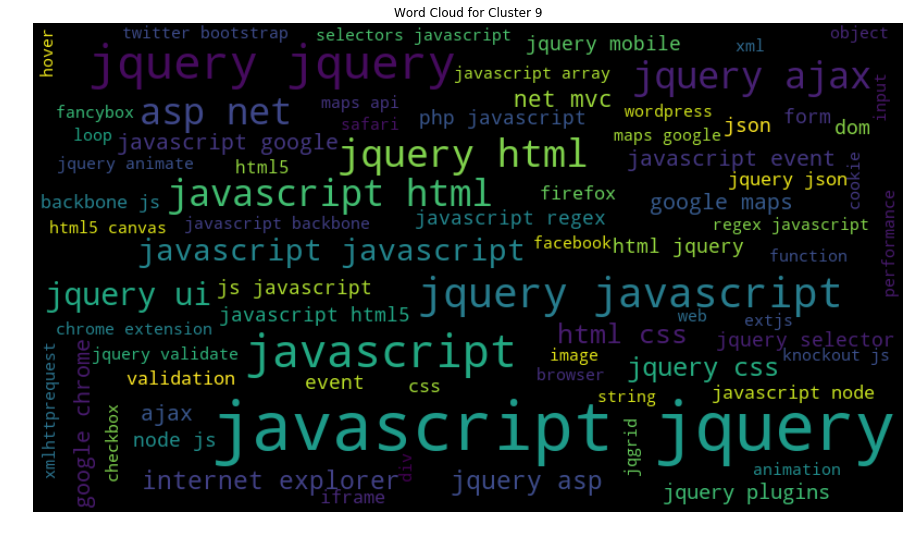

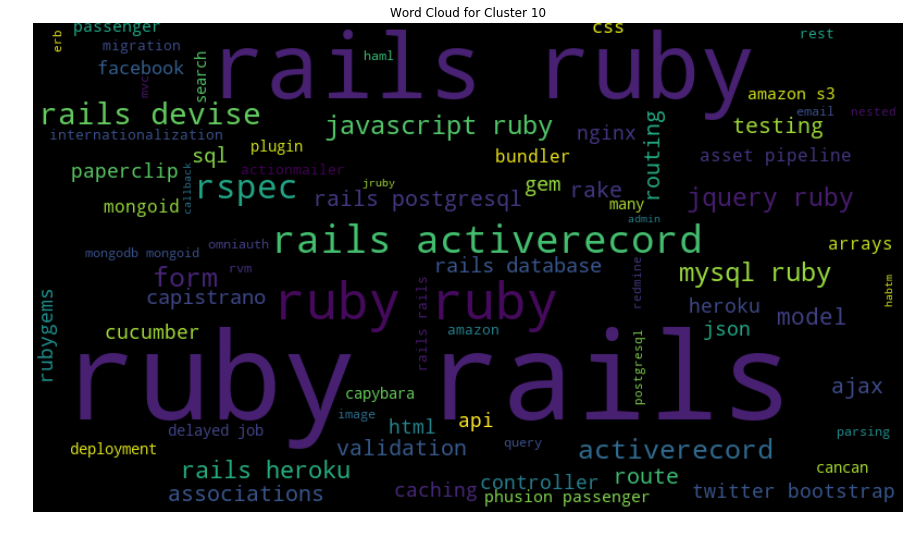

In [40]:
#Plot word clouds of similar tags
word_clouds(kmeans_object, tags_corpus)

## Analysis from the tags clusters.

In Cluster 1, we see a lot of tags related to the PHP language. We can also see the word facebook, which is logical considering the fact that facebook is built using PHP. So this has clustered a lot of questions on PHP.

In Cluster 2, we see most of the tags belonging  to visual studio and it's related frameworks like asp .net, mvc framworks etc.

In Cluster 3, we see a lot of questions about Java and it's various frameworks - like spring, hybernate, swing etc. So this cluster mostly contains questions on Java.

In Cluster 4, This has grouped questions mostly on sql server. How to use SQL server from various programming languages. We see the tags asp and net occuring together alamost always. The tags python and django occurs together most of the times.

In Cluster 5, we see a lot of tags related to IOS development. This cluster has essentially grouped questions on developing IOS application, problems related to Iphone. We can also see this cluster contaisn objective C as a frequent tag. This seems logical as ios apps are mostly written in objective c.

In Cluster 6, it mostly has tags related to android application development using java and java ide's like eclipse etc.

In Cluster 7, PHP occurs a lot with mysql. This is logical, since PHP related questins are azsked ery often in StackOverflow (as we have seen above), and most of the questions has queries related to using sql database in PHP.

In Cluster 8, multithreading occurs a lot of times with Java. Cluster 8 has grouped tags related to parallelization using Java. I have inferred this by seeing the following words - multithreading, semaphore, asynchronous, multiprocessing etc. These tags have a hi=gh tendency to occur together.

In Cluster 9, most of the tags belongs to frontend languages. We can see tags like html, jquery, javascript, chrome, node, ajax, various frontent plugins etc. All these tags has a very high tendency to occur together.

In Cluster 10, we see most of the tags belonging to ruby on rails. There are a few tags which occurs together with ruby on rails. Few of them are - rails, activeboard, hereku, rails devise, ruby, mongodb etc.

In general, we see that there are some tags which has a higher tendency to occur with some specific sets of tags. For example, if someone has tagged a question as android, there is a higher likelihood that it might also contain the tag java. Similarly, if one has tagged a question as IOS, there is a higher chance that the tags objective c might be present as well.


<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [47]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [ ]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

### We will create a new data base to store the sampled and preprocessed questions __

In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2] #question=body

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("Number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "\nAverage length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Average length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print("Percentage of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1169
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:47:05.946582


In [0]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [0]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('ef code first defin one mani relationship differ key troubl defin one zero mani relationship entiti ef object model look like use fluent api object composit pk defin batch id batch detail id use fluent api object composit pk defin batch detail id compani id map exist databas tpt basic idea submittedtransact zero mani submittedsplittransact associ navig realli need one way submittedtransact submittedsplittransact need dbcontext class onmodelcr overrid map class lazi load occur submittedtransact submittedsplittransact help would much appreci edit taken advic made follow chang dbcontext class ad follow onmodelcr overrid must miss someth get follow except thrown submittedtransact key batch id batch detail id zero one mani submittedsplittransact key batch detail id compani id rather assum convent creat relationship two object configur requir sinc obvious wrong',)
--------------------------------------------------------------------------------------------------

In [5]:
#Taking 1 Million entries to a dataframe.
read_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [6]:
preprocessed_data.head()

question  \
0  chang cpu soni vaio pcg grx tri everywher find...   
1  display size grayscal qimag qt abl display ima...   
2  datagrid selecteditem set back null eventtocom...   
3  filter string collect base listview item resol...   
4  disabl home button without use type keyguard c...   

                                                tags  
0  cpu motherboard sony-vaio replacement disassembly  
1                                         c++ qt qt4  
2                               mvvm silverlight-4.0  
3            c# winforms string listview collections  
4  android android-layout android-manifest androi...

In [7]:
print("Number of data points in sample :", preprocessed_data.shape[0])
print("Number of dimensions :", preprocessed_data.shape[1])

Number of data points in sample : 999999
Number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [10]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

### We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [14]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [15]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

### A variance plot which shows the percentage of variance retained with different number of tags.

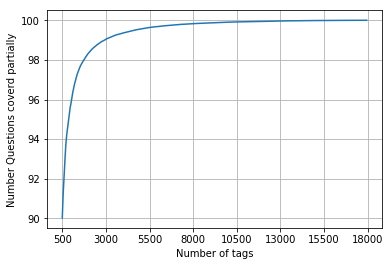

With  5500 tags we are covering  99.035 % of questions


In [14]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("With ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [15]:
multilabel_yx = tags_to_choose(5500)
print("Number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

Number of questions that are not covered : 9645 out of  999999


In [16]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("Number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35422
Number of tags taken : 5500 ( 15.527073570097679 %)


#### We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [17]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [18]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


<h2>4.3 Featurizing data </h2>

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:09:50.460431


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Diamensions of train data X: (799999, 88244) Y : (799999, 5500)
Diamensions of test data X: (200000, 88244) Y: (200000, 5500)


In [0]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

"\nfrom skmultilearn.adapt import MLkNN\nclassifier = MLkNN(k=21)\n\n# train\nclassifier.fit(x_train_multilabel, y_train)\n\n# predict\npredictions = classifier.predict(x_test_multilabel)\nprint(accuracy_score(y_test,predictions))\nprint(metrics.f1_score(y_test, predictions, average = 'macro'))\nprint(metrics.f1_score(y_test, predictions, average = 'micro'))\nprint(metrics.hamming_loss(y_test,predictions))\n\n"

<h2> 4.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [0]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier1 = OneVsRestclassifier1(SGDclassifier1(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier1.fit(x_train_multilabel, y_train)
predictions = classifier1.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.081965
macro f1 score : 0.0963020140154
micro f1 scoore : 0.374270748817
hamming loss : 0.00041225090909090907
Precision recall report :
              precision    recall  f1-score   support

          0       0.62      0.23      0.33     15760
          1       0.79      0.43      0.56     14039
          2       0.82      0.55      0.66     13446
          3       0.76      0.42      0.54     12730
          4       0.94      0.76      0.84     11229
          5       0.85      0.64      0.73     10561
          6       0.70      0.30      0.42      6958
          7       0.87      0.61      0.72      6309
          8       0.70      0.40      0.50      6032
          9       0.78      0.43      0.55      6020
         10       0.86      0.62      0.72      5707
         11       0.52      0.17      0.25      5723
         12       0.55      0.10      0.16      5521
         13       0.59      0.25      0.35      4722
         14       0.61      0.22      0.32      4468


In [0]:
from sklearn.externals import joblib
joblib.dump(classifier1, 'lr_with_equal_weight.pkl') 

<h2> 4.5 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [5]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [22]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Special characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [23]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [24]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("Number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print("\nAverage length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print("Average length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print("Percentage of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Number of questions completed= 100000
Number of questions completed= 200000
Number of questions completed= 300000
Number of questions completed= 400000
Number of questions completed= 500000

Average length of questions(Title+Body) before processing: 1239
Average length of questions(Title+Body) after processing: 424
Percentage of questions containing code: 57
Time taken to run this cell : 0:25:16.112802


In [25]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

### Sample quesitons after preprocessing of data __

In [26]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

### Loading Preprocessed data with 3 times more title weight __

In [9]:
#Taking 0.5 Million entries to a dataframe.
read_db = 'Titlemoreweight.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [10]:
preprocessed_data.head()

question  \
0  dynam datagrid bind silverlight dynam datagrid...   
1  dynam datagrid bind silverlight dynam datagrid...   
2  java.lang.noclassdeffounderror javax servlet j...   
3  java.sql.sqlexcept microsoft odbc driver manag...   
4  better way updat feed fb php sdk better way up...   

                                  tags  
0          c# silverlight data-binding  
1  c# silverlight data-binding columns  
2                             jsp jstl  
3                            java jdbc  
4        facebook api facebook-php-sdk

In [11]:
print("Number of data points in sample :", preprocessed_data.shape[0])
print("Number of dimensions :", preprocessed_data.shape[1])

Number of data points in sample : 500000
Number of dimensions : 2


### Converting string Tags to multilable output variables __ 

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

### Selecting 500 Tags __

In [16]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

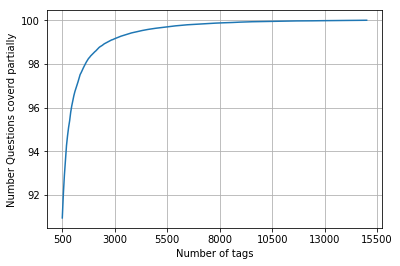

With  5500 tags we are covering  99.157 % of questions
With  500 tags we are covering  90.956 % of questions


In [17]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("With ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("With ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [18]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("Number of questions that are not covered: ", questions_explained_fn(500),"out of ", total_qs)

Number of questions that are not covered:  45221 out of  500000


In [44]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [46]:
print("Number of data points in train data: ", y_train.shape)
print("Number of data points in test data: ", y_test.shape)

Number of data points in train data:  (400000, 500)
Number of data points in test data:  (100000, 500)


<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [48]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:14.145802


In [49]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 94927) Y : (400000, 500)
Dimensions of test data X: (100000, 94927) Y: (100000, 500)


<h3> 4.5.3 Applying Logistic Regression with SGDClassifier and OneVsRest Classifier </h3>

In [54]:
start = datetime.now()
classifier2 = OneVsRestclassifier2(SGDclassifier2(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier2.fit(x_train_multilabel, y_train)
predictions = classifier2.predict (x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23682
Hamming loss  0.00277832
Micro-average quality numbers
Precision: 0.7222, Recall: 0.3263, F1-measure: 0.4495
Macro-average quality numbers
Precision: 0.5515, Recall: 0.2584, F1-measure: 0.3354

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.64      0.76      5519
          1       0.68      0.26      0.38      8190
          2       0.82      0.38      0.51      6529
          3       0.81      0.43      0.57      3231
          4       0.81      0.41      0.54      6430
          5       0.81      0.34      0.48      2879
          6       0.87      0.50      0.63      5086
          7       0.88      0.54      0.67      4533
          8       0.60      0.13      0.22      3000
          9       0.81      0.52      0.64      2765
         10       0.59      0.17      0.27      3051
         11       0.69      0.33      0.45      3009
         12       0.65      0.24      0.35      2630
         13       0.71

/home/saugata/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/saugata/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/saugata/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
joblib.dump(classifier2, 'lr_with_more_title_weight.pkl') 

<h3> 4.5.4 Applying Logistic Regression with LogisticRegression and OneVsRest Classifier </h3>

In [0]:
start = datetime.now()
classifier3 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier3.fit(x_train_multilabel, y_train)
predictions_2 = classifier3.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))

precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25108
Hamming loss  0.00270302
Micro-average quality numbers
Precision: 0.7172, Recall: 0.3672, F1-measure: 0.4858
Macro-average quality numbers
Precision: 0.5570, Recall: 0.2950, F1-measure: 0.3710
             precision    recall  f1-score   support

          0       0.94      0.72      0.82      5519
          1       0.70      0.34      0.45      8190
          2       0.80      0.42      0.55      6529
          3       0.82      0.49      0.61      3231
          4       0.80      0.44      0.57      6430
          5       0.82      0.38      0.52      2879
          6       0.86      0.53      0.66      5086
          7       0.87      0.58      0.70      4533
          8       0.60      0.13      0.22      3000
          9       0.82      0.57      0.67      2765
         10       0.60      0.20      0.30      3051
         11       0.68      0.38      0.49      3009
         12       0.62      0.29      0.40      2630
         13       0.73      0.30      0.43   

In [ ]:
joblib.dump(classifier_2, 'lr_with_more_title_weight2.pkl') 

<h1> 5. Assignments </h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparameter tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>

<h3>Loading Preprocessed data with 3 times more title weight </h3>

In [4]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        sampled_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

#Display 10 questions.
sampled_data.head(10)

question  \
0  dynam datagrid bind silverlight dynam datagrid...   
1  dynam datagrid bind silverlight dynam datagrid...   
2  java.lang.noclassdeffounderror javax servlet j...   
3  java.sql.sqlexcept microsoft odbc driver manag...   
4  better way updat feed fb php sdk better way up...   
5  btnadd click event open two window record ad b...   
6  sql inject issu prevent correct form submiss p...   
7  countabl subaddit lebesgu measur countabl suba...   
8  hql equival sql queri hql equival sql queri hq...   
9  undefin symbol architectur i386 objc class skp...   

                                  tags  
0          c# silverlight data-binding  
1  c# silverlight data-binding columns  
2                             jsp jstl  
3                            java jdbc  
4        facebook api facebook-php-sdk  
5               javascript asp.net web  
6                            php forms  
7         real-analysis measure-theory  
8                        hibernate hql  
9             iphone email-integration

In [5]:
print("Number of data points in sample :", sampled_data.shape[0])
print("Number of dimensions :", sampled_data.shape[1])

Number of data points in sample : 500000
Number of dimensions : 2


### Converting string Tags to multilable output variables __ 

In [6]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(sampled_data['tags'])

### We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [7]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

<h3>Selecting top 500 Tags __ </h3>

In [8]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=sampled_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

<h3>A variance plot showing the numbe rof partial covergae of questions with various tag numbers. </h3>

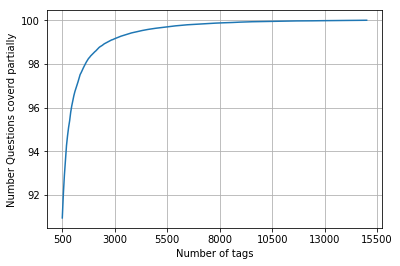

With  5500 tags we are covering  99.157 % of questions
With  500 tags we are covering  90.956 % of questions


In [9]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("With ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("With ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("Number of questions that are not covered: ", questions_explained_fn(500),"out of ", total_qs)

Number of questions that are not covered:  45221 out of  500000


In [11]:
train_datasize = 400000

x_train=sampled_data.head(train_datasize)
x_test=sampled_data.tail(sampled_data.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:sampled_data.shape[0],:]

In [12]:
print("Number of data points in train data: ", y_train.shape)
print("Number of data points in test data: ", y_test.shape)

del(multilabel_yx, multilabel_y)

Number of data points in train data:  (400000, 500)
Number of data points in test data:  (100000, 500)


<h3> 5.1 Featurizing the questions with BOW vectorizer - 1,2,3,4 - Grams </h3>

In [14]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=100000, analyzer='word', tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to featurize the class labels using BOW representation :", datetime.now() - start)

#Sorting indices to get rid of Value Error: WRITEBACKIFCOPY base is read-only
x_train_multilabel.sort_indices()
x_test_multilabel.sort_indices()

print("Dimensions of train and test data:")
print("x_train:",x_train_multilabel.shape, "y_train :",y_train.shape)
print("x_test:",x_test_multilabel.shape, "y_test :",y_test.shape)

#Save the data for later use.
import pickle
with open('x_train_multilabel.pkl', 'wb') as file:
    pickle.dump(x_train_multilabel, file)

with open('y_train.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('x_test_multilabel.pkl', 'wb') as file:
    pickle.dump(x_test_multilabel, file)

with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

Time taken to featurize the class labels using BOW representation : 0:10:20.406049
Dimensions of train and test data:
x_train: (400000, 95585) y_train : (400000, 500)
x_test: (100000, 95585) y_test : (100000, 500)


In [4]:
import pickle

with open('x_train_multilabel.pkl', 'rb') as file:
    x_train_multilabel = pickle.load(file)
    
with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('x_test_multilabel.pkl', 'rb') as file:
    x_test_multilabel = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
print("Dimensions of train and test data:")
print("x_train:",x_train_multilabel.shape, "y_train :",y_train.shape)
print("x_test:",x_test_multilabel.shape, "y_test :",y_test.shape)

Dimensions of train and test data:
x_train: (400000, 95585) y_train : (400000, 500)
x_test: (100000, 95585) y_test : (100000, 500)


<h3>5.2 Applying Logistic Regression with OneVsRest Classifier </h3>

In [6]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', C=1.0, random_state=0), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

import joblib
joblib.dump(classifier, 'lr_with_more_title_weight_lr_ovr.pkl') 

Accuracy : 0.21224
Hamming loss  0.00313274
Micro-average quality numbers
Precision: 0.5686, Recall: 0.4097, Micro F1-measure: 0.4762
Macro-average quality numbers
Precision: 0.4511, Recall: 0.3346, Macro F1-measure: 0.3807
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      5519
           1       0.52      0.41      0.46      8190
           2       0.64      0.47      0.54      6529
           3       0.68      0.53      0.59      3231
           4       0.66      0.49      0.56      6430
           5       0.62      0.42      0.50      2879
           6       0.74      0.57      0.64      5086
           7       0.75      0.61      0.68      4533
           8       0.34      0.18      0.24      3000
           9       0.70      0.59      0.64      2765
          10       0.42      0.29      0.35      3051
          11       0.59      0.45      0.51      3009
          12       0.48      0.36      0.41      2630
          13       

['lr_with_more_title_weight_lr_ovr.pkl']

<h3>5.3.1 Applying Logistic Regression (SGDClassifier with 'log' loss) with OneVsRest Classifier </h3>

In [4]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.001, penalty='l1', random_state=0), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

import joblib
joblib.dump(classifier, 'lr_with_more_title_weight_sgd_logloss_ovr.pkl') 

Accuracy : 0.1868
Hamming loss  0.00326424
Micro-average quality numbers
Precision: 0.5507, Recall: 0.3310, Micro F1-measure: 0.4135
Macro-average quality numbers
Precision: 0.4102, Recall: 0.2470, Macro F1-measure: 0.2879
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      5519
           1       0.54      0.21      0.30      8190
           2       0.70      0.36      0.48      6529
           3       0.54      0.47      0.50      3231
           4       0.76      0.40      0.52      6430
           5       0.71      0.35      0.47      2879
           6       0.67      0.57      0.62      5086
           7       0.75      0.63      0.68      4533
           8       0.48      0.15      0.23      3000
           9       0.55      0.60      0.58      2765
          10       0.44      0.22      0.29      3051
          11       0.77      0.28      0.41      3009
          12       0.54      0.27      0.36      2630
          13       0

['lr_with_more_title_weight_sgd_logloss_ovr.pkl']

<h3>5.3.2 Hyperparameter 'alpha' tuning to increase performance on Logistic Regression model (SGDClassifier with 'log' loss) with OneVsRest Classifier</h3>

In [ ]:
'''from sklearn.model_selection import cross_val_score
models = []
cross_val_scores=[]
   
def get_best_estimate_sgd(x_train_multilabel, y_train): #9:47
    start = datetime.now()
    alpha_vals = np.logspace(-4,1,20)
    for alpha in alpha_vals:
        score = []
        classifier=OneVsRestClassifier(SGDClassifier(loss='log', alpha=alpha, penalty='l1')) 
        f1_scores = cross_val_score(classifier, x_train_multilabel, y_train, cv=10, scoring='f1_micro', n_jobs=-1) ##Perform 10-fold cross validation on the train set 
        cross_val_scores.append(f1_scores.mean())
        models.append(classifier)
        print("For alpha = {}, the Cross Validation Micro F1 Score is = {}".format(alpha,f1_scores.mean()))
           
    max_score = max(cross_val_scores)
    best_estimator = models[cross_val_scores.index(max_score)]
        
    print("\n\nThe best estimator obtained using Hyperparameter tuning: ",best_estimator)
    print("The best Micro Average F1-Score obtained using Hyperparameter tuning: ",max_score)
    print("Time taken to perform 10 Fold Cross validation: ",datetime.now()-start)
    
    return(best_estimator)'''

In [6]:
#Function to determine the best estimator using Hyperparameter tuning by using simple for loops. Not using GridSearch for improving time complexity. Not using K-Fold cross validation. Very basic for loop to determine best params
#Note: We can't use probability scores using SGDClassifiers. Hence, we need to Calibrate the model
from sklearn.model_selection import RandomizedSearchCV

st=datetime.now()

def get_RandomSearchCV(x_train_multilabel, y_train):
    '''This function will determine the best hyperparameters using KFold CV and GridSearchCV, using K fold cross validation. '''
    from sklearn.model_selection import KFold
    n_folds = 5
    cv_kfold = KFold(n_splits=n_folds).split(x_train_multilabel)
    alpha = np.logspace(-4,4,30)
    params  = {"estimator__alpha":alpha}
    base_estimator=OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1', random_state=0), n_jobs=-1)
    rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=cv_kfold, scoring='f1_micro', n_jobs=-1, verbose=1)
    rsearch_cv.fit(x_train_multilabel, y_train)
    return  rsearch_cv

#Get the best estimator after performing Random Search Cross Validation.
rsearch_cv = get_RandomSearchCV(x_train_multilabel,y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 212.1min
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 402.7min finished


Time taken to perform hyperparameter tuning:  7:03:10.630894
Best estimator:  OneVsRestClassifier(estimator=SGDClassifier(alpha=0.00018873918221350977, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Best Cross Validation Score:  0.46735172370575395


<h3>5.3.3 Applying Logistic Regression model (SGDClassifier with 'log' loss) with OneVsRest Classifier with the best estimator obtained using random search.</h3>

In [8]:
classifier=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.00018873918221350977, average=False, class_weight=None,early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',power_t=0.5, random_state=0, shuffle=True, tol=None,validation_fraction=0.1, verbose=0, warm_start=False),n_jobs=-1)

In [9]:
#Train the model with the best estimator obtained from above
start_t = datetime.now()
#classifier = rsearch_cv.best_estimator_
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("\nAccuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start_t)

import joblib
joblib.dump(classifier, 'lr_with_more_title_weight_sgd_log_ovr_hyp_tuned.pkl')


Accuracy : 0.14065
Hamming loss  0.00400758
Micro-average quality numbers
Precision: 0.4251, Recall: 0.4339, Micro F1-measure: 0.4295
Macro-average quality numbers
Precision: 0.3574, Recall: 0.3544, Macro F1-measure: 0.3430


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.69      0.75      0.72      5519
           1       0.44      0.39      0.41      8190
           2       0.59      0.46      0.52      6529
           3       0.42      0.56      0.48      3231
           4       0.56      0.51      0.54      6430
           5       0.46      0.49      0.48      2879
           6       0.55      0.63      0.59      5086
           7       0.63      0.66      0.65      4533
           8       0.30      0.21      0.24      3000
           9       0.48      0.67      0.56      2765
          10       0.38      0.28      0.32      3051
          11       0.55      0.44      0.49      3009
          12       0.39      0.40      0.39      2630
          13       0.36      0.41      0.39      1426
          14       0.69      0.65      0.67      2548
          15       0.38      0.34      0.36      2371
          16       0.40      0.34      0.37       873
          17       0.60    

['lr_with_more_title_weight_sgd_log_ovr_hyp_tuned.pkl']

<h3>5.4 Applying Linear-SVM (SGDClassifier with 'hinge' loss) with OneVsRest Classifier</h3>

In [8]:
start = datetime.now()

#Build the model
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1', verbose=1), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

#Save the model for future use.
import joblib
joblib.dump(classifier, 'linear_SVM_with_more_title_weight_sgd_hinge_ovr.pkl') 

Accuracy : 0.11029
Hamming loss  0.00594184
Micro-average quality numbers
Precision: 0.2872, Recall: 0.4785, Micro F1-measure: 0.3589
Macro-average quality numbers
Precision: 0.2076, Recall: 0.4065, Macro F1-measure: 0.2671
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      5519
           1       0.44      0.45      0.45      8190
           2       0.53      0.51      0.52      6529
           3       0.51      0.63      0.56      3231
           4       0.53      0.54      0.54      6430
           5       0.41      0.49      0.45      2879
           6       0.58      0.62      0.60      5086
           7       0.57      0.68      0.62      4533
           8       0.21      0.23      0.22      3000
           9       0.56      0.66      0.60      2765
          10       0.30      0.37      0.33      3051
          11       0.48      0.50      0.49      3009
          12       0.36      0.44      0.39      2630
          13       

['linear_SVM_with_more_title_weight_sgd_hinge_ovr.pkl']

<h3>5.5.1 Hyperparameter tuning 'alpha' to increase the performance, for SGD Classifier with Hinge Loss using GridSearchCV</h3>

In [10]:
#Perform Grid Search.
from sklearn.model_selection import GridSearchCV
start = datetime.now()

def get_GridSearchCV(x_train_multilabel, y_train):
    '''This function will determine the best hyperparameters using KFold CV and GridSearchCV, using 10 fold cross validation. '''
    from sklearn.model_selection import KFold
    n_folds = 10
    cv_kfold = KFold(n_splits=n_folds).split(x_train_multilabel)
    alpha = np.logspace(-4,4,12)
    params  = {"estimator__alpha":alpha}
    base_estimator=OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))
    rsearch_cv = GridSearchCV(estimator=base_estimator, param_grid=params, cv=cv_kfold, scoring='f1_micro', n_jobs=-1, verbose=1)
    rsearch_cv.fit(x_train_multilabel, y_train)
    return  rsearch_cv

#Get the best estimator after performing Grid Search Cross Validation.
gsearch_cv = get_GridSearchCV(x_train_multilabel,y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-start)
print("Best estimator: ",gsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",gsearch_cv.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 202.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 671.7min finished


Time taken to perform hyperparameter tuning:  11:27:57.905896
Best estimator:  OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0005336699231206312, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)
Best Cross Validation Score:  0.45956534873702376


<h3>5.5.2 Applying SGDClassifier with Hinge Loss with OneVsRest Classifier with the best estimator obtained from Grid Search.</h3>

In [11]:
start = datetime.now()

#Fit the dataset with the best estimator.
classifier = gsearch_cv.best_estimator_
classifier.fit(x_train_multilabel, y_train)
y_pred = classifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, y_pred))
print("Hamming loss ",metrics.hamming_loss(y_test,y_pred))

precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, y_pred))
print("Time taken to train the model :", datetime.now() - start)

import joblib
joblib.dump(classifier, 'lr_with_more_title_weight_lr_sdg_hinge_ovr_hyp_tuned.pkl') 

Accuracy : 0.1622
Hamming loss  0.00349386
Micro-average quality numbers
Precision: 0.4965, Recall: 0.3630, Micro F1-measure: 0.4194
Macro-average quality numbers
Precision: 0.3466, Recall: 0.2873, Macro F1-measure: 0.2946
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      5519
           1       0.52      0.25      0.34      8190
           2       0.59      0.43      0.50      6529
           3       0.56      0.53      0.55      3231
           4       0.62      0.45      0.52      6430
           5       0.56      0.47      0.51      2879
           6       0.70      0.57      0.63      5086
           7       0.76      0.59      0.66      4533
           8       0.31      0.19      0.24      3000
           9       0.61      0.58      0.59      2765
          10       0.45      0.14      0.21      3051
          11       0.61      0.40      0.48      3009
          12       0.58      0.30      0.40      2630
          13       0

['lr_with_more_title_weight_lr_sdg_hinge_ovr_hyp_tuned.pkl']

<h3> 5.6 Applying Logistic Regression on BOW vectorizer - 1,2 - Grams + Hyperparameter tuning</h3>

In [15]:
from datetime import datetime

#Taking 25000 most important features and number of n_grams = (1,2)
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=25000, analyzer='word', tokenizer = lambda x: x.split(), ngram_range=(1,2))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to featurize the class labels using BOW representation :", datetime.now() - start)

#Sorting indices to get rid of Value Error: WRITEBACKIFCOPY base is read-only
x_train_multilabel.sort_indices()
x_test_multilabel.sort_indices()

print("Dimensions of train and test data:")
print("x_train:",x_train_multilabel.shape, "y_train :",y_train.shape)
print("x_test:",x_test_multilabel.shape, "y_test :",y_test.shape)

#Save the data for later use.
import pickle
with open('x_train_multilabel_bigrm.pkl', 'wb') as file:
    pickle.dump(x_train_multilabel, file)

with open('y_train_bigrm.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('x_test_multilabel_bigrm.pkl', 'wb') as file:
    pickle.dump(x_test_multilabel, file)

with open('y_test_bigrm.pkl', 'wb') as file:
    pickle.dump(y_test, file)

Time taken to featurize the class labels using BOW representation : 0:01:31.044764
Dimensions of train and test data:
x_train: (400000, 25000) y_train : (400000, 500)
x_test: (100000, 25000) y_test : (100000, 500)


In [3]:
import pickle

with open('x_train_multilabel_bigrm.pkl', 'rb') as file:
    x_train_multilabel = pickle.load(file)
    
with open('y_train_bigrm.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('x_test_multilabel_bigrm.pkl', 'rb') as file:
    x_test_multilabel = pickle.load(file)
    
with open('y_test_bigrm.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
print("Dimensions of train and test data:")
print("x_train:",x_train_multilabel.shape, "y_train :",y_train.shape)
print("x_test:",x_test_multilabel.shape, "y_test :",y_test.shape)

Dimensions of train and test data:
x_train: (400000, 25000) y_train : (400000, 500)
x_test: (100000, 25000) y_test : (100000, 500)


In [5]:
#Function to determine the best estimator using Hyperparameter tuning by using simple for loops. Not using GridSearch for improving time complexity. Not using K-Fold cross validation. Very basic for loop to determine best params
#Note: We can't use probability scores using SGDClassifiers
import warnings
warnings.filterwarnings("ignore")

models = []
f1_scores=[]
def get_best_estimate_lr(x_train_multilabel, y_train, x_test_multilabel, y_test):
    c_vals = [1000,100,10,1,0.1,0.01]
    for C in tqdm(c_vals):
        score = []
        classifier=OneVsRestClassifier(LogisticRegression(penalty='l2', C=1.0, multi_class='ovr', solver='lbfgs', random_state=0), n_jobs=-1)
        classifier.fit(x_train_multilabel, y_train)
        models.append(classifier)
        f1_scores.append(f1_score(y_test, classifier.predict(x_test_multilabel), average='micro')) #predictions: f1_score(y_test, classifier.predict(x_test_multilabel), average='micro')
           
    max_score = max(f1_scores)
    best_estimator = models[f1_scores.index(max_score)]
        
    print("The best estimator obtained using Hyperparameter tuning: ",best_estimator)
    print("The best Micro Average F1-Score obtained using Hyperparameter tuning: ",max_score)
    
    return(best_estimator)

best_estimator=get_best_estimate_lr(x_train_multilabel, y_train, x_test_multilabel, y_test)

100%|██████████| 6/6 [4:10:02<00:00, 2621.96s/it]  


The best estimator obtained using Hyperparameter tuning:  OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
The best Micro Average F1-Score obtained using Hyperparameter tuning:  0.46704424197652467


In [6]:
#Train the model with best estimator
start = datetime.now()
classifier = best_estimator
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("\nAccuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Micro F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, Macro F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to train the model :", datetime.now() - start)

import joblib
joblib.dump(classifier, 'lr_with_more_title_weight_lr_bow_2grm_hyp_tuned.pkl') 


Accuracy : 0.21343
Hamming loss  0.00311664
Micro-average quality numbers
Precision: 0.5758, Recall: 0.3928, Micro F1-measure: 0.4670
Macro-average quality numbers
Precision: 0.4568, Recall: 0.3173, Macro F1-measure: 0.3706


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.89      0.74      0.80      5519
           1       0.58      0.38      0.46      8190
           2       0.73      0.44      0.55      6529
           3       0.68      0.52      0.59      3231
           4       0.68      0.48      0.56      6430
           5       0.67      0.40      0.50      2879
           6       0.79      0.56      0.65      5086
           7       0.77      0.61      0.68      4533
           8       0.42      0.17      0.24      3000
           9       0.68      0.61      0.64      2765
          10       0.43      0.27      0.34      3051
          11       0.57      0.44      0.49      3009
          12       0.48      0.34      0.40      2630
          13       0.56      0.37      0.44      1426
          14       0.78      0.58      0.66      2548
          15       0.47      0.31      0.37      2371
          16       0.60      0.29      0.39       873
          17       0.78    

['lr_with_more_title_weight_lr_bow_2grm_hyp_tuned.pkl']

## Conclusion:

#### What we did throughout this experiment:

The objective of this experiment was to suggest tags based on the questions that are posted in StackOverflow.
StackOverflow, as we know, is a website which serves as a platform of millions to programmers around the globe to ask and answer questions. 
There are a wide range of questions that are asked in StackOverflow, from simple computer science questions to the most advance topics in programming. There's
a multitude of different domains that are there in StackOverflow. In order to correctly classify a question to it's correct domain, StackOverflow uses this wonderful 
system of predicting tags based on the query questions. In this way, questions are given tags which results in the questions being answered by relevant people.
Imagine, we have a question on Python - "What is the Pythonic way to scrap web pages?". Now, based on this questions StackOverflow may give it tags like 'Python', 'Web-Scrapping' etc.
Now, had there been no system of tags, this questions would have been sent to anyone who is a member of StackOverflow. However, since we have these tags 'Python' and 'Web-Scrapping' as 
suggested by StackOverflow, the questions will only go to people who are interested in 'Python' and 'Web-Scrapping'. This increases productivity. It also reduces the hassle of a question being answered 
by an user who doesn't work with Python. Overall, this increases the user experience of all the users who come to StackOverflow.

Here, we are given a dataset which contains questions from almost 6 million users. Each question has corresponding tags associated to it. Based on the given data, we have to build a system which 
will predict tags based on new unseen questions. Each question is described by the following features - 'Title', 'Body', 'Tags'. The title and body text will be used to predict the tags. Remember, there
may be more than one tags associated to a question. So it's not only a multiclass problem, but it's also a multilabel problem. In such a scenario the best metric that we would chose is the Micro Average F1 Score.
We have chosen this metric to make use of the weighted average of the F1 score of each class. Micro averaged F1 score calculates metrics globally by counting the total true positives, false negatives and false positives. 
This is a better metric when we have class imbalance. We have to keep the following things in mind:

1. We have to predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. There is no strict latency constraints, which means given a query point, the program can take few minutes to correctly predict the tags.

The first thing we have done is perform some basic Exploratory Data Analysis on the given dataset. EDA is an important step to understand which features are important in the context of the
problem and which features are not. In the EDA section we got information about the following: 

1. Number of times each question appeared in the database
2. Distribution of number of tags per question. (Avg. number of tags per question: 2.899440)
3. Total number of unique tags present in the dataset (42048)
4. Number of times each tag has appeared across the entire dataset. 
5. c#, java, php are the most frequent tags in StackOverflow. (c# occurs 331505 number of times)

From, what we have observed till now is each question can be associated to multiple tags. So we can treat this as a multilabel problem. Afer the EDA is done, we have performed some data cleaning tasks.
Due to limitation in computing power, we will sample only 1 million data points. In the cleaning phase, we have seperated the code snippets from the body, we have removed special characters from
the title as well as the body. We have removed all the necessary stopwords, we have used Snowball stemmer to stem the words.

After the data cleaning step has been done we will plot a variance plot which explains how much information across the entire dataset is retained with the number of tags. Rememeber there are 42000 
unique tags that we have. We see that more than 99% variance is retained with number of tags = 5500 and more than 90% variance is retained when we use 500 tags. On building ML models with 5500
tags we see that it takes roughly 6-8 hours to train a Logistic Regression model. So, for the sake of time, we will use only 500 tags to train all our future models.

We will convert each of these 500 tags to binary outputs using the Count Vectorizer object of scikit learn. We will sample 0.5 million data points with 500 tags, and 3 times more weight added
to the titles. We have featurized the data using TFIDF and BOW (1-4 grams) vectorizers and use several models with Hyperparameter tuning to get the highest value of micro f1 score. We will use a simple Logistic
Regression model, we will use SGD Classifier with both 'log' loss and 'hinge' loss. At the end we have done a comparison between all the models that we have used to conclude which one actually
performed better for our problem. It turns out that the simple Logistic Regression model works best for our problem set. Since, this is a multilabel problem we will use the OnvVsRest classifier 
along with our base estimators to train the model. Please find below the list of models that we have trained along with their class precision, recall values and micro f1 score.	


### Comparing performance of all the models.

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from prettytable import PrettyTable

#Table 1
print("TF-IDF with 1 million datapoints: ")
print("="*33)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro f1"]
table.add_row(["LogisticRegression", 'TF-IDF ', 0.081965,0.000412,0.53,0.26,0.096302])
print(table)
print("="*93+"\n"+"="*93+"\n\n")

#Table 2
print("TF-IDF with 0.5 million datapoints: ")
print("="*35)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro f1"]
table.add_row(["SGDClassifier(loss=log) ",'TF-IDF ',  0.23682, 0.002779, 0.7222, 0.3263, 0.4495])
table.add_row(["LogisticRegression", 'TF-IDF ', 0.25108,0.00270302,0.7172,0.3672,0.4858])
print(table)
print("="*99+"\n"+"="*99+"\n\n")

#Table 3
print("\nBOW with (1,4)-grams and 0.5M datapoints: ")
print("="*41)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro f1"]
table.add_row(["Logistic Regression",'BOW', 0.21224, 0.00313,0.5686,0.4097,0.4762])
table.add_row(["SGDClassifier(loss=log)", 'BOW', 0.1868, 0.00326,0.5507,0.3310,0.4135])
table.add_row(["SGDClassifier(loss=log) HypTuned", 'BOW', 0.14065, 0.00400758,0.4251,0.4339,0.4295])
table.add_row(["SGDClassifier(loss=hinge)", 'BOW', 0.11029, 0.005941,0.2872,0.4785,0.3589])
table.add_row(["SGDClassifier(loss=hinge) HypTuned", 'BOW', 0.1622, 0.003493,0.4965,0.3630,0.4194])
print(table)
print("="*109+"\n"+"="*109+"\n\n")

#Table 4
print("\nBOW with (1,2)-grams and 0.5M datapoints: ")
print("="*41)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro f1"]
table.add_row(["Logistic Regression (hyp tuned)",'BOW', 0.21343, 0.00311664,0.5758,0.3928,0.4670])
print(table)
print("="*94+"\n"+"="*94+"\n\n")

TF-IDF with 1 million datapoints: 
+--------------------+------------+----------+--------------+-----------+--------+----------+
|       Model        | Vectorizer | Accuracy | Hamming loss | Precision | Recall | Micro f1 |
+--------------------+------------+----------+--------------+-----------+--------+----------+
| LogisticRegression |  TF-IDF    | 0.081965 |   0.000412   |    0.53   |  0.26  | 0.096302 |
+--------------------+------------+----------+--------------+-----------+--------+----------+


TF-IDF with 0.5 million datapoints: 
+--------------------------+------------+----------+--------------+-----------+--------+----------+
|          Model           | Vectorizer | Accuracy | Hamming loss | Precision | Recall | Micro f1 |
+--------------------------+------------+----------+--------------+-----------+--------+----------+
| SGDClassifier(loss=log)  |  TF-IDF    | 0.23682  |   0.002779   |   0.7222  | 0.3263 |  0.4495  |
|    LogisticRegression    |  TF-IDF    | 0.25108  |  0.